In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

import torch.nn as nn
import torch.optim as optim
from modeling.cnn import CNNModel
from modeling.deepCNN import DeepCNNModel
from trainer.train import train_model
from dataloader.data_loader import get_dataloaders

PyTorch version: 2.2.0
Torchvision version: 0.17.0


In [2]:
import sys
sys.path.append("..")  # Add the parent directory to the Python path
sys.path.append("/Users/mia/landslide_susceptibility_model")  # Replace with the actual path

In [3]:
# Paths to the data directories
image_dir = "/Users/mia/landslide_susceptibility_model/data/tiles/images"
label_dir = "/Users/mia/landslide_susceptibility_model/data/tiles/labels"

# Get data loaders for the full dataset
train_loader, val_loader, test_loader = get_dataloaders(
    image_dir=image_dir, 
    label_dir=label_dir, 
    batch_size=16  # Adjust batch size based on your memory capacity
)

Computed mean: [0.11505754318553671, 2586.379745381809, 22.17206176435364, 164.72643304426725], std: [0.1214328488496645, 2015.5044986394996, 15.076717818035617, 109.11107022826218]


In [6]:
# Check device availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize the CNN model
model = CNNModel(input_channels=4)  # Adjust input_channels if needed

# Define the loss function and optimizer
criterion = nn.BCELoss(weight=torch.tensor([60000]).to(device))  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [7]:
# Train the model
run1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs= 30,  # Adjust based on how long you want to train
    validate_every=5,  # Validate every 2 epochs
    device=device,
    checkpoint_dir="model_runs/checkpoints/cnn_run"  # Save checkpoints for the full run
)

Epoch [1/30], Training Loss: 6553.6897
Epoch [2/30], Training Loss: 532.3238
Epoch [3/30], Training Loss: 520.3045
Epoch [4/30], Training Loss: 530.1024
Epoch [5/30], Training Loss: 497.8969
Epoch [5/30], Validation Loss: 756.8335
Epoch [6/30], Training Loss: 509.0510
Epoch [7/30], Training Loss: 500.5325
Epoch [8/30], Training Loss: 482.8496
Epoch [9/30], Training Loss: 501.2505
Epoch [10/30], Training Loss: 489.5148
Epoch [10/30], Validation Loss: 706.5258
Epoch [11/30], Training Loss: 494.0179
Epoch [12/30], Training Loss: 495.6215
Epoch [13/30], Training Loss: 492.7127
Epoch [14/30], Training Loss: 497.6066
Epoch [15/30], Training Loss: 486.7294
Epoch [15/30], Validation Loss: 725.9548
Epoch [16/30], Training Loss: 498.4815
Epoch [17/30], Training Loss: 497.6707
Epoch [18/30], Training Loss: 501.5070
Epoch [19/30], Training Loss: 493.1975
Epoch [20/30], Training Loss: 494.8877
Epoch [20/30], Validation Loss: 707.3937
Epoch [21/30], Training Loss: 495.2895
Epoch [22/30], Training Lo

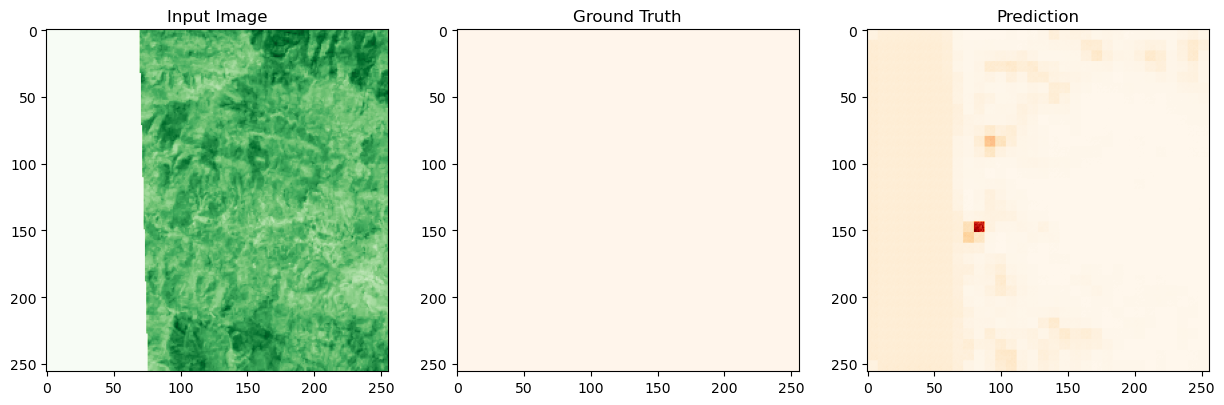

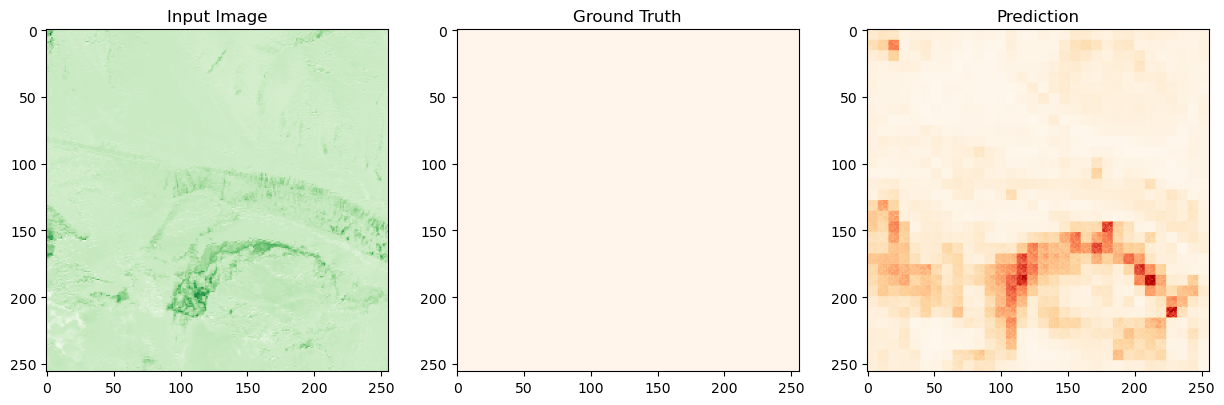

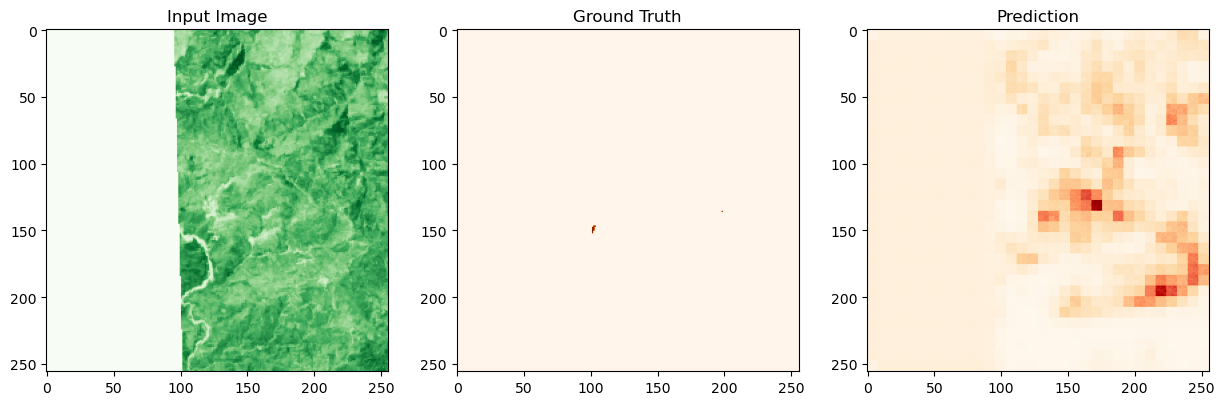

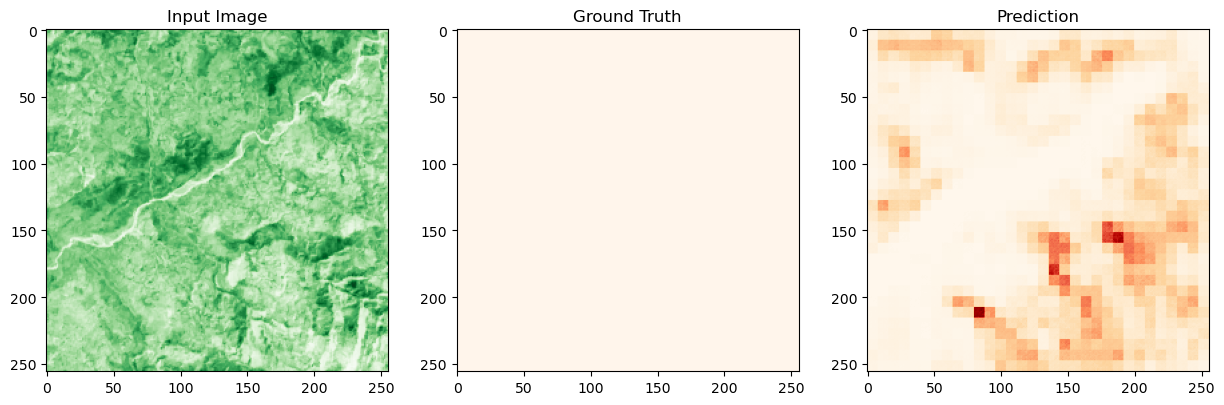

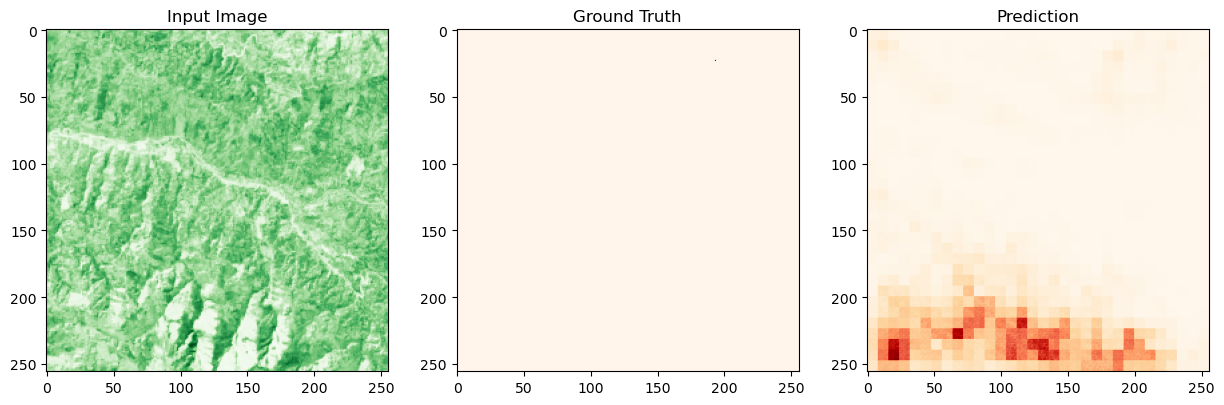

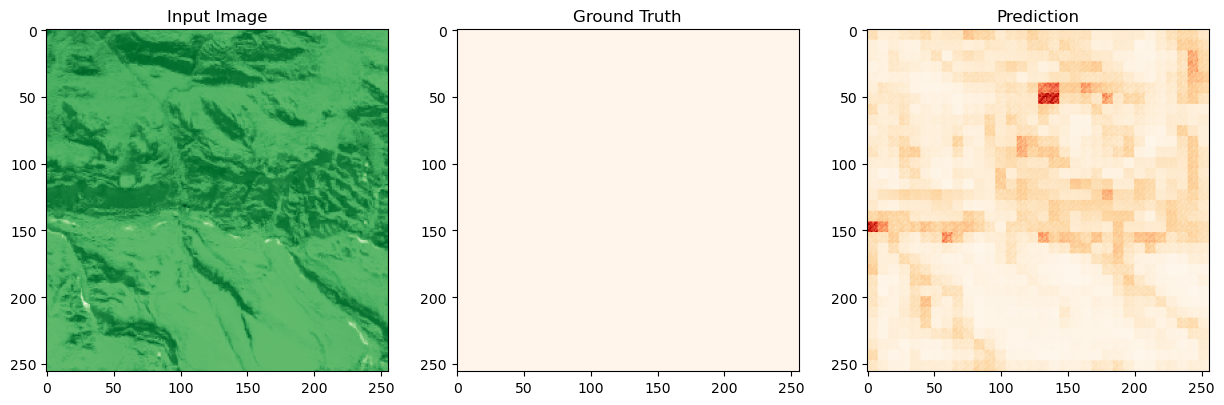

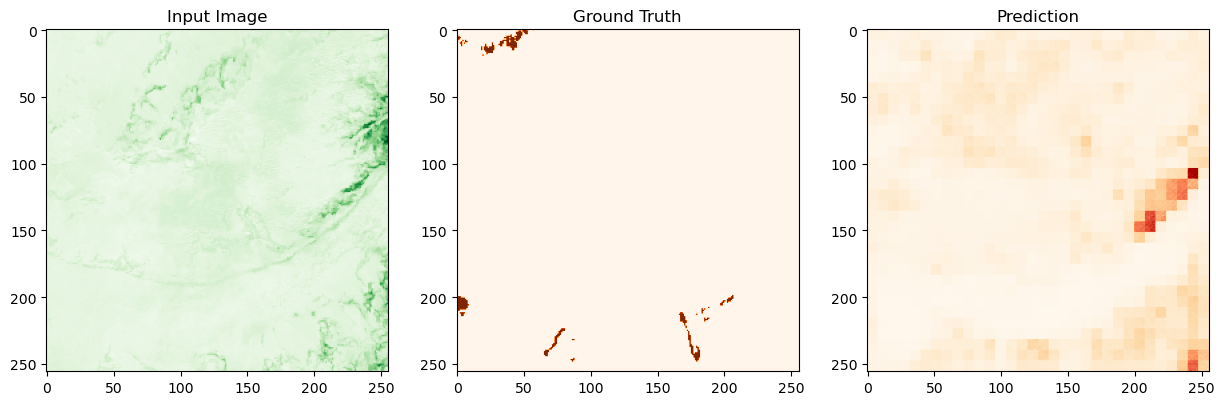

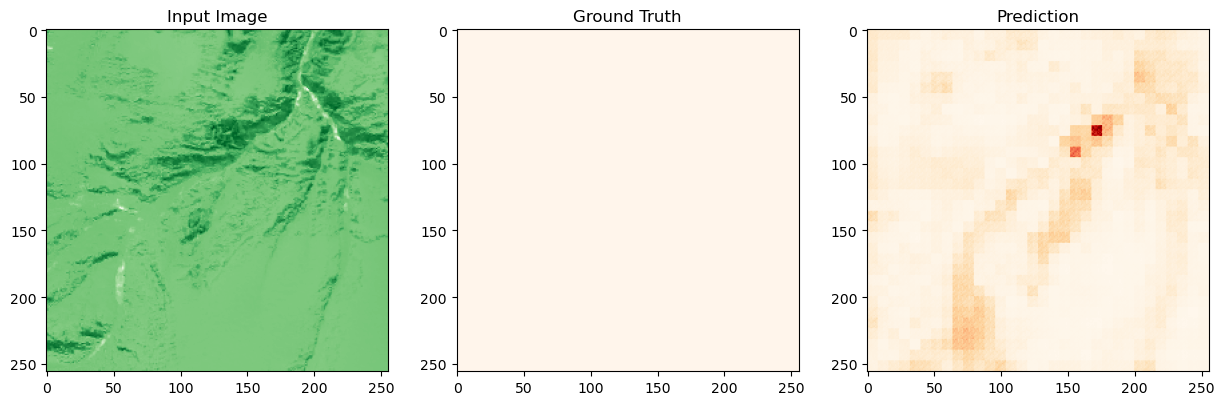

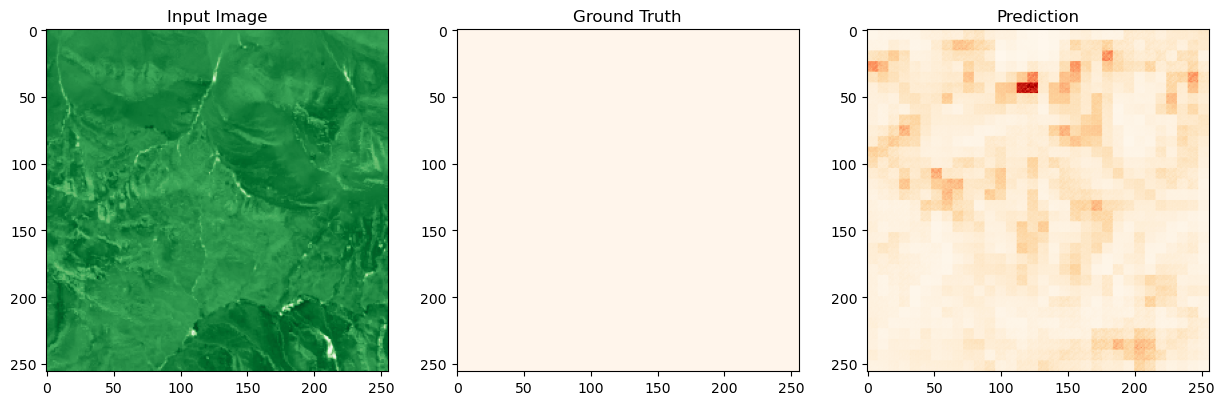

In [8]:
import matplotlib.pyplot as plt

# Example: Visualize a single image, ground truth, and prediction
for images, labels in val_loader:
    with torch.no_grad():
        predictions = model(images.to(device)).cpu().numpy()

    # Visualize first sample
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[0, 0], cmap="Greens")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(labels[0, 0], cmap="Oranges")
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(predictions[0, 0], cmap="OrRd")
    plt.show()


In [9]:
from evaluation.offline_evaluation import eval_model
test_metrics = eval_model(model, test_loader, device)

Predicting Samples: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


In [10]:
print(f"Average Precision: {test_metrics.average_precision:.4f}")
print(f"Optimal Threshold: {test_metrics.metrics_op.threshold_op:.4f}")
print(f"Precision at OP: {test_metrics.metrics_op.precision_op:.4f}")
print(f"Recall at OP: {test_metrics.metrics_op.recall_op:.4f}")
print(f"F1 Score at OP: {test_metrics.metrics_op.f1_score_op:.4f}")

Average Precision: 0.0202
Optimal Threshold: 0.5038
Precision at OP: 0.0301
Recall at OP: 0.1435
F1 Score at OP: 0.0498


In [11]:
eval_metrics = eval_model(model, test_loader, device)

# Print the evaluation summary
print(eval_metrics.summarize_to_str())

Predicting Samples: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


AP=0.02023 (T=0.50384) precision@T=0.03010 recall@T=0.14353 f1@T=0.04977
